# B2B SasS company - Customer support queue analysis

In [ ]:
!pip install plotly
!pip install dash dash-bootstrap-components
!pip install jupyter-dash

In [2]:
# Import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import dash
from dash import Dash, dcc, html, Input, Output, callback
import dash_bootstrap_components as dbc
from jupyter_dash import JupyterDash


In [3]:
# Read csv file
file_path = "../data/query_results-2024-08-28_43438.csv"
df = pd.read_csv(file_path)

In [4]:
df.head()

,ticket_id,user_id,company_id,issue_category,created_at,match_id,ticket_id.1,staff_id,matched_at,company_id.1,company_name,company_size,wait_time,wait_time_exceeded
0,1,11,35,Account,2024-06-19 15:19:41.967908,1,1,44,2024-06-19 15:21:26.967908,35,Company_35,16,00:01:45,0
1,2,32,21,Technical,2024-03-09 02:13:25.967908,2,2,32,2024-03-09 02:21:02.967908,21,Company_21,31,00:07:37,0
2,3,373,32,General Inquiry,2024-02-21 07:56:30.967908,3,3,16,2024-02-21 08:06:17.967908,32,Company_32,47,00:09:47,0
3,4,223,8,Account,2024-07-09 11:15:32.967908,4,4,32,2024-07-09 11:17:30.967908,8,Company_8,15,00:01:58,0
4,5,78,10,Billing,2024-04-09 21:06:46.967908,5,5,45,2024-04-09 21:08:42.967908,10,Company_10,12,00:01:56,0


In [5]:
# Display basic information about the dataframe
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   ticket_id           5000 non-null   int64 
 1   user_id             5000 non-null   int64 
 2   company_id          5000 non-null   int64 
 3   issue_category      5000 non-null   object
 4   created_at          5000 non-null   object
 5   match_id            5000 non-null   int64 
 6   ticket_id.1         5000 non-null   int64 
 7   staff_id            5000 non-null   int64 
 8   matched_at          5000 non-null   object
 9   company_id.1        5000 non-null   int64 
 10  company_name        5000 non-null   object
 11  company_size        5000 non-null   int64 
 12  wait_time           5000 non-null   object
 13  wait_time_exceeded  5000 non-null   int64 
dtypes: int64(9), object(5)
memory usage: 547.0+ KB
None


- calculate wait time using columns (matched_at - created_at) and compare it with wait_time column in dataframe to ensure those values match

In [6]:
# Display column names
print("Available columns:")
print(df.columns)

# Convert 'created_at' and 'matched_at' to datetime
for col in ['created_at', 'matched_at']:
    df[col] = pd.to_datetime(df[col])

# Calculate wait time in minutes
df['calculated_wait_time'] = (df['matched_at'] - df['created_at']).dt.total_seconds() / 60

# Compare with 'wait_time' column (assuming it's in HH:MM:SS format)
df['wait_time_minutes'] = df['wait_time'].apply(lambda x: sum(int(i) * 60 ** j for j, i in enumerate(reversed(x.split(':')))) / 60)

comparison = df[['wait_time', 'wait_time_minutes', 'calculated_wait_time']].head()
print("\
Comparison of wait times:")
print(comparison)

# Check if the calculated wait time matches the existing wait time
matches = (df['wait_time_minutes'].round(2) == df['calculated_wait_time'].round(2)).all()
print(f"\
Do the calculated wait times match the existing wait times? {matches}")


Available columns:
Index(['ticket_id', 'user_id', 'company_id', 'issue_category', 'created_at',
       'match_id', 'ticket_id.1', 'staff_id', 'matched_at', 'company_id.1',
       'company_name', 'company_size', 'wait_time', 'wait_time_exceeded'],
      dtype='object')
Comparison of wait times:
  wait_time  wait_time_minutes  calculated_wait_time
0  00:01:45           1.750000              1.750000
1  00:07:37           7.616667              7.616667
2  00:09:47           9.783333              9.783333
3  00:01:58           1.966667              1.966667
4  00:01:56           1.933333              1.933333
Do the calculated wait times match the existing wait times? True


## Data Cleanup

- Remove 'wait_time_exceeded' column if it exists
- Convert 'created_at' and 'matched_at' columns to datetime type
- Convert 'wait_time' to timedelta type
- Remove duplicate columns (ticket_id and company_id)
- Consider encoding 'issue_category' as categorical data

In [7]:
# Read csv file
file_path = "../data/query_results-2024-08-28_43438.csv"
df = pd.read_csv(file_path)
df.head()

,ticket_id,user_id,company_id,issue_category,created_at,match_id,ticket_id.1,staff_id,matched_at,company_id.1,company_name,company_size,wait_time,wait_time_exceeded
0,1,11,35,Account,2024-06-19 15:19:41.967908,1,1,44,2024-06-19 15:21:26.967908,35,Company_35,16,00:01:45,0
1,2,32,21,Technical,2024-03-09 02:13:25.967908,2,2,32,2024-03-09 02:21:02.967908,21,Company_21,31,00:07:37,0
2,3,373,32,General Inquiry,2024-02-21 07:56:30.967908,3,3,16,2024-02-21 08:06:17.967908,32,Company_32,47,00:09:47,0
3,4,223,8,Account,2024-07-09 11:15:32.967908,4,4,32,2024-07-09 11:17:30.967908,8,Company_8,15,00:01:58,0
4,5,78,10,Billing,2024-04-09 21:06:46.967908,5,5,45,2024-04-09 21:08:42.967908,10,Company_10,12,00:01:56,0


In [8]:
# Remove 'wait_time_exceeded' column if it exists
if 'wait_time_exceeded' in df.columns:
    df = df.drop('wait_time_exceeded', axis=1)
    
# Convert 'created_at' and 'matched_at' columns to datetime type
df["created_at"] = pd.to_datetime(df["created_at"])
df["matched_at"] = pd.to_datetime(df["matched_at"])

# Convert 'wait_time' to timedelta type
df['wait_time'] = pd.to_timedelta(df['wait_time'])

# Remove duplicate columns
df = df.drop(["ticket_id.1", "company_id.1"], axis=1)

# Encode 'issue_category' as categorical data
df['issue_category'] = df['issue_category'].astype('category')

In [9]:
# Display the cleaned dataframe info and head
print(df.info())
print("\
Cleaned DataFrame Head:")
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype          
---  ------          --------------  -----          
 0   ticket_id       5000 non-null   int64          
 1   user_id         5000 non-null   int64          
 2   company_id      5000 non-null   int64          
 3   issue_category  5000 non-null   category       
 4   created_at      5000 non-null   datetime64[ns] 
 5   match_id        5000 non-null   int64          
 6   staff_id        5000 non-null   int64          
 7   matched_at      5000 non-null   datetime64[ns] 
 8   company_name    5000 non-null   object         
 9   company_size    5000 non-null   int64          
 10  wait_time       5000 non-null   timedelta64[ns]
dtypes: category(1), datetime64[ns](2), int64(6), object(1), timedelta64[ns](1)
memory usage: 395.8+ KB
None
Cleaned DataFrame Head:


,ticket_id,user_id,company_id,issue_category,created_at,match_id,staff_id,matched_at,company_name,company_size,wait_time
0,1,11,35,Account,2024-06-19 15:19:41.967908,1,44,2024-06-19 15:21:26.967908,Company_35,16,0 days 00:01:45
1,2,32,21,Technical,2024-03-09 02:13:25.967908,2,32,2024-03-09 02:21:02.967908,Company_21,31,0 days 00:07:37
2,3,373,32,General Inquiry,2024-02-21 07:56:30.967908,3,16,2024-02-21 08:06:17.967908,Company_32,47,0 days 00:09:47
3,4,223,8,Account,2024-07-09 11:15:32.967908,4,32,2024-07-09 11:17:30.967908,Company_8,15,0 days 00:01:58
4,5,78,10,Billing,2024-04-09 21:06:46.967908,5,45,2024-04-09 21:08:42.967908,Company_10,12,0 days 00:01:56


In [10]:
# Check for any remaining issues
df.isnull().sum()

ticket_id         0
user_id           0
company_id        0
issue_category    0
created_at        0
match_id          0
staff_id          0
matched_at        0
company_name      0
company_size      0
wait_time         0
dtype: int64

In [11]:
# Unique values in 'issue_category'
df['issue_category'].unique()

['Account', 'Technical', 'General Inquiry', 'Billing']
Categories (4, object): ['Account', 'Billing', 'General Inquiry', 'Technical']

In [12]:
# Data types:
df.dtypes

ticket_id                   int64
user_id                     int64
company_id                  int64
issue_category           category
created_at         datetime64[ns]
match_id                    int64
staff_id                    int64
matched_at         datetime64[ns]
company_name               object
company_size                int64
wait_time         timedelta64[ns]
dtype: object

### EDA:

- Key metrics
- Analyze wait times and their distribution
- Investigate relationships between company size and wait times
- Explore patterns in issue categories

In [13]:
df.head()

,ticket_id,user_id,company_id,issue_category,created_at,match_id,staff_id,matched_at,company_name,company_size,wait_time
0,1,11,35,Account,2024-06-19 15:19:41.967908,1,44,2024-06-19 15:21:26.967908,Company_35,16,0 days 00:01:45
1,2,32,21,Technical,2024-03-09 02:13:25.967908,2,32,2024-03-09 02:21:02.967908,Company_21,31,0 days 00:07:37
2,3,373,32,General Inquiry,2024-02-21 07:56:30.967908,3,16,2024-02-21 08:06:17.967908,Company_32,47,0 days 00:09:47
3,4,223,8,Account,2024-07-09 11:15:32.967908,4,32,2024-07-09 11:17:30.967908,Company_8,15,0 days 00:01:58
4,5,78,10,Billing,2024-04-09 21:06:46.967908,5,45,2024-04-09 21:08:42.967908,Company_10,12,0 days 00:01:56


In [14]:
# Calculate wait time in minutes
df['wait_time_minutes'] = (df['matched_at'] - df['created_at']).dt.total_seconds() / 60

# Calculate key metrics
total_tickets = len(df)
avg_wait_time = df['wait_time_minutes'].mean()
wait_time_threshold = df['wait_time_minutes'].quantile(0.95)
tickets_exceeding_threshold = (df['wait_time_minutes'] > wait_time_threshold).sum()

print(f"Total Tickets: {total_tickets}")
print(f"Average Wait Time: {avg_wait_time:.2f} minutes")
print(f"95th Percentile Wait Time: {wait_time_threshold:.2f} minutes")
print(f"Tickets Exceeding Threshold: {tickets_exceeding_threshold}")

Total Tickets: 5000
Average Wait Time: 7.25 minutes
95th Percentile Wait Time: 23.35 minutes
Tickets Exceeding Threshold: 250


In [15]:
df["wait_time_minutes"].describe()

count    5000.000000
mean        7.245033
std        10.634479
min         0.000000
25%         2.000000
50%         4.216667
75%         8.650000
max       192.466667
Name: wait_time_minutes, dtype: float64

In [16]:
# Calculate the required percentiles
percentiles = df['wait_time_minutes'].quantile([0.75, 0.80, 0.85, 0.90, 0.95])
percentiles

0.75     8.650000
0.80    10.016667
0.85    12.433333
0.90    16.166667
0.95    23.351667
Name: wait_time_minutes, dtype: float64

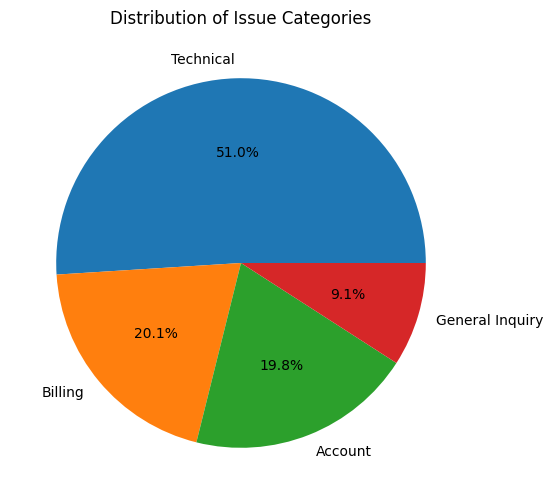

In [17]:
# # Analyze the distribution of issue_category
plt.figure(figsize=(10, 6))
df['issue_category'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Distribution of Issue Categories')
plt.ylabel('')
# plt.savefig('../images/issue_categories_pie.png')
# plt.close()
plt.show()

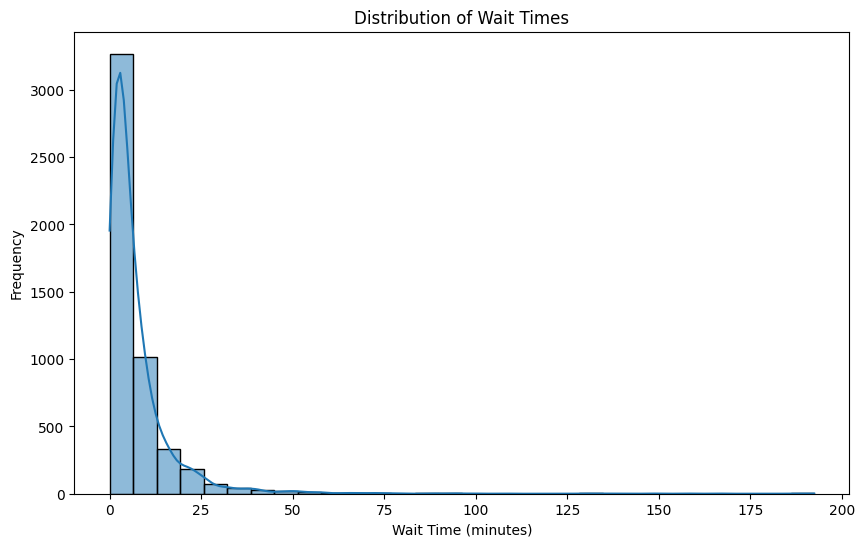

In [18]:
# Analyze the distribution of wait times
plt.figure(figsize=(10, 6))
sns.histplot(df['wait_time_minutes'], bins=30, kde=True)
plt.title('Distribution of Wait Times')
plt.xlabel('Wait Time (minutes)')
plt.ylabel('Frequency')
# plt.savefig('../images/wait_time_histogram.png')
# plt.close()
plt.show()

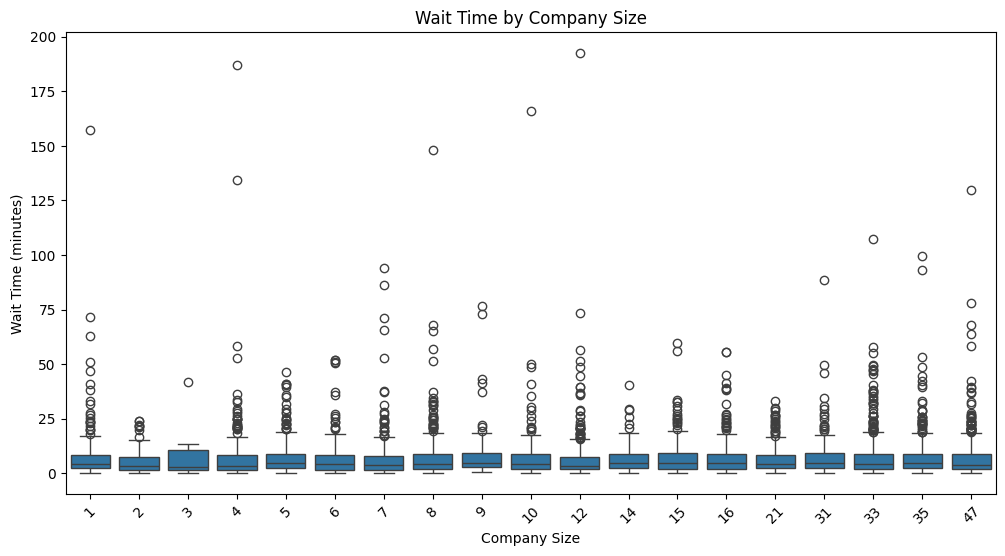

In [19]:
# Investigate relationships between company size and wait times
plt.figure(figsize=(12, 6))
sns.boxplot(x='company_size', y='wait_time_minutes', data=df)
plt.title('Wait Time by Company Size')
plt.xlabel('Company Size')
plt.ylabel('Wait Time (minutes)')
plt.xticks(rotation=45)
# plt.savefig('../images/wait_time_by_company_size.png')
# plt.close()
plt.show()

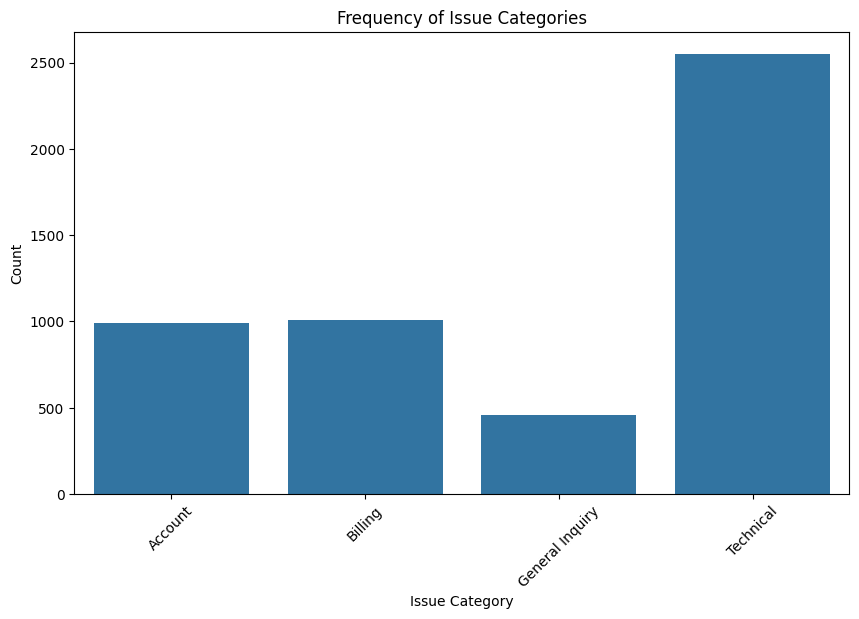

In [20]:
# Explore patterns in issue categories
plt.figure(figsize=(10, 6))
sns.countplot(x='issue_category', data=df)
plt.title('Frequency of Issue Categories')
plt.xlabel('Issue Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


In [21]:
# Calculate average wait time for high-value customers (assuming companies larger than median size are high-value)
median_company_size = df['company_size'].median()
high_value_avg_wait_time = df[df['company_size'] > median_company_size]['wait_time_minutes'].mean()

print(f"\
Average wait time for high-value customers: {high_value_avg_wait_time:.2f} minutes")

Average wait time for high-value customers: 7.20 minutes


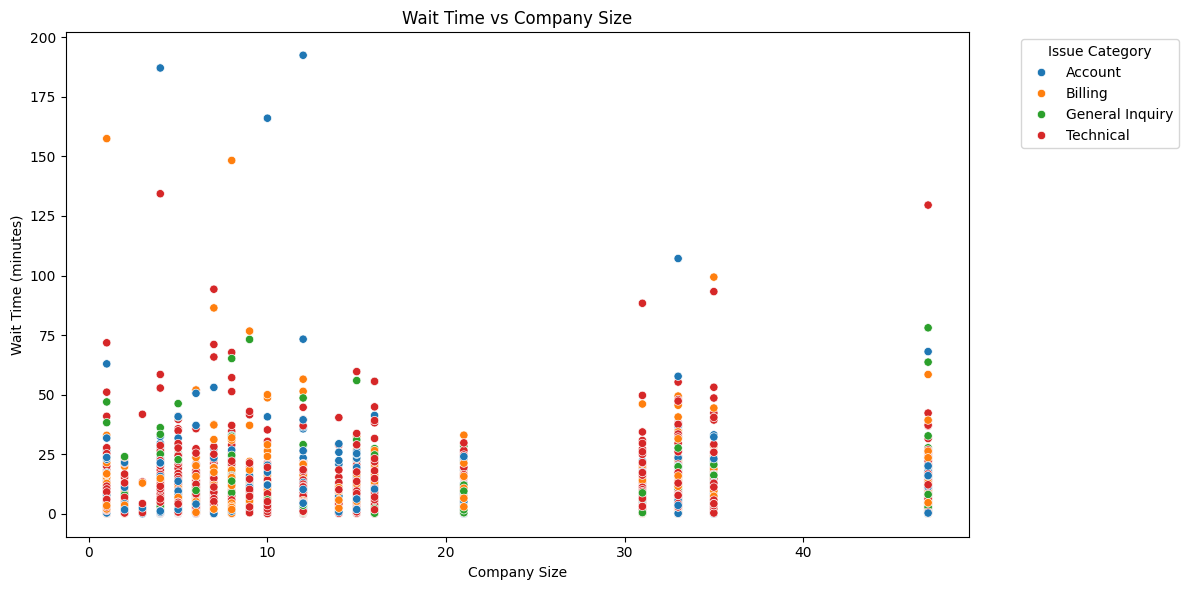

In [22]:
# Create scatter plot of wait time vs company size
plt.figure(figsize=(12, 6))
sns.scatterplot(x='company_size', y='wait_time_minutes', hue='issue_category', data=df)
plt.title('Wait Time vs Company Size')
plt.xlabel('Company Size')
plt.ylabel('Wait Time (minutes)')
plt.legend(title='Issue Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
# plt.savefig('../images/wait_time_vs_company_size.png')
# plt.close()
plt.show()

### Business questions:

- how long are users waiting?
- how long is too long to wait? -- when we get complaints, how long were the complainers waiting.
- how many users are waiting too long?
- how is the problem of "waiting too long" distributed across users from different sized companies

#### Answers to business questions based on the above analysis:

1. **How long are users waiting?**

    The average wait time for users is approximately `7.25` minutes.

2. **How long is too long to wait?**

    The 95th percentile wait time is `23.35` minutes. This can be considered as a threshold for "too long" to wait.

3. **How many users are waiting too long?**

    There are `250` tickets where the wait time exceeds the 95th percentile threshold.

4. **How is the problem of "waiting too long" distributed across users from different sized companies?**

    The average wait time for high-value customers (companies larger than the median size) is `7.20` minutes. The distribution of wait times across different company sizes was visualized in the box-plot and scatter plot above.


- Total Tickets: `5000`

- Average Wait Time: `7.25` minutes

- 95th Percentile Wait Time: `23.35` minutes

- Tickets Exceeding Threshold: `250`

- Average wait time for high-value customers: `7.20` minutes

### Dashboard

The dashboard includes the following pages:

- **Operational Status**: Displays total tickets, average wait time, and tickets exceeding the wait time threshold, along with a pie chart of issue categories.
- **Wait Time Statistics**: Shows a histogram of wait times and a box plot of wait time by company size.
- **Recommendations for Improvement**: Provides recommendations for reducing wait times for high-value customers and includes a scatter plot of wait time vs. company size.
  
You can navigate between these pages using the navigation bar at the top of the dashboard.

In [23]:
# # Create the Dash app
# app = Dash(__name__, external_stylesheets=[dbc.themes.BOOTSTRAP])

# Create the JupyterDash app
app = JupyterDash(__name__, external_stylesheets=[dbc.themes.BOOTSTRAP])

# Define the layout for each page
def create_operational_status():
    total_tickets = len(df)
    avg_wait_time = df['wait_time_minutes'].mean()
    exceeded_threshold = (df['wait_time_minutes'] > wait_time_threshold).sum()
    
    return dbc.Container([
        html.H1("Operational Status"),
        dbc.Row([
            dbc.Col(dbc.Card(dbc.CardBody([
                html.H4("Total Tickets", className="card-title"),
                html.H2(f"{total_tickets}", className="card-text")
            ]))),
            dbc.Col(dbc.Card(dbc.CardBody([
                html.H4("Average Wait Time", className="card-title"),
                html.H2(f"{avg_wait_time:.2f} minutes", className="card-text")
            ]))),
            dbc.Col(dbc.Card(dbc.CardBody([
                html.H4("Tickets Exceeding Threshold", className="card-title"),
                html.H2(f"{exceeded_threshold}", className="card-text")
            ])))
        ]),
        dcc.Graph(figure=px.pie(df, names='issue_category', title='Distribution of Issue Categories'))
    ])

def create_wait_time_statistics():
    return dbc.Container([
        html.H1("Wait Time Statistics"),
        dcc.Graph(figure=px.histogram(df, x='wait_time_minutes', nbins=30, title='Distribution of Wait Times')),
        dcc.Graph(figure=px.box(df, x='company_size', y='wait_time_minutes', title='Wait Time by Company Size'))
    ])

def create_recommendations():
    high_value_customers = df[df['company_size'] > df['company_size'].median()]
    avg_wait_time_high_value = high_value_customers['wait_time_minutes'].mean()
    
    return dbc.Container([
        html.H1("Recommendations for Improvement"),
        html.P(f"Average wait time for high-value customers: {avg_wait_time_high_value:.2f} minutes"),
        html.Ul([
            html.Li("Implement a priority queue for high-value customers"),
            html.Li("Increase staff during peak hours"),
            html.Li("Provide self-service options for common issues"),
            html.Li("Conduct regular training for support staff to improve efficiency")
        ]),
        dcc.Graph(figure=px.scatter(df, x='company_size', y='wait_time_minutes', 
                                    color='issue_category', title='Wait Time vs Company Size'))
    ])

# Define the layout of the app
app.layout = html.Div([
    dcc.Location(id='url', refresh=False),
    dbc.NavbarSimple(
        children=[
            dbc.NavItem(dbc.NavLink("Operational Status", href="/")),
            dbc.NavItem(dbc.NavLink("Wait Time Statistics", href="/wait-time")),
            dbc.NavItem(dbc.NavLink("Recommendations", href="/recommendations")),
        ],
        brand="Customer Support Dashboard",
        brand_href="/",
        color="primary",
        dark=True,
    ),
    html.Div(id='page-content')
])

# Callback to update page content
@app.callback(Output('page-content', 'children'), Input('url', 'pathname'))
def display_page(pathname):
    if pathname == '/wait-time':
        return create_wait_time_statistics()
    elif pathname == '/recommendations':
        return create_recommendations()
    else:
        return create_operational_status()

# Run the app
if __name__ == '__main__':
    app.run_server(debug=True)

print("Dashboard created successfully. You can now run this script to start the Dash server and view the dashboard in your web browser.")

Dash app running on http://127.0.0.1:8050/
Dashboard created successfully. You can now run this script to start the Dash server and view the dashboard in your web browser.


/usr/local/python/3.12.1/lib/python3.12/site-packages/dash/dash.py:556: UserWarning:

JupyterDash is deprecated, use Dash instead.
See https://dash.plotly.com/dash-in-jupyter for more details.



In [24]:
# save cleaned df to csv
df.to_csv("../data/clean-dataset-sq.csv")